In [1]:
import json
import os
import urllib.request
import torch
from torch.utils.data import Dataset, DataLoader
from functools import partial
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import random
import time

C:\Users\Majid\anaconda3\envs\LLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download and open the instruction Dataset.
def download_and_load_file(file_path, url, is_jsonl=False):
    # Download if not exists
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode('utf-8')
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(text_data)

    # Load file
    with open(file_path, 'r', encoding='utf-8') as file:
        if is_jsonl:  # JSON Lines format
            data = [json.loads(line) for line in file if line.strip()]
        else:  # Standard JSON array
            data = json.load(file)
    return data

file_path = 'instruction-data.json'
url = 'https://raw.githubusercontent.com/majidarasteh/Large-Language-Model_LLM/refs/heads/main/Resources/instruction-data.json'

data = download_and_load_file(file_path, url, is_jsonl=False)  # set True if file is JSONL
print('Number of entries:', len(data))
print('First entry:', data[6])


Number of entries: 1100
First entry: {'instruction': 'Translate the following sentence into French.', 'input': 'Where is the nearest restaurant?', 'output': 'Où est le restaurant le plus proche?'}


In [3]:
"""
    * Convert a single dataset entry into a text prompt suitable for instruction-following models.
    * The function expects an entry dictionary with this structure:
        entry = {
                'instruction': 'Translate to French',  # Required
                'input': 'Hello world',                # Optional
                'output': 'Bonjour le monde'           # Not used in this function
            }
    * The function returns a string that combines the instruction and input into a standard prompt format.

    * Prepares instruction-following prompt in a consistent format
      - Includes "instruction" always.
      - Includes "input" only if it exists
      - Output is a single string ready for tokenization
"""

def format_input(entry):
    # Base instruction template
    instruction_text = (
        "Below is an instruction that describes a task. "
        f"\n# Instruction:\n{entry['instruction']}"
    )

    # Add input section only if it exists
    input_text = f"\n# Input:\n{entry['input']}" if entry.get("input") else ""

    # The function returns a string that combines the instruction and input into a standard prompt format.
    return instruction_text + input_text


In [4]:
"""
    * This code is preparing an input-output pair for instruction fine-tuning a language model.
    * data[6] → selects the 7th entry in your dataset (Python is 0-indexed).
    * format_input() → formats it into the instruction prompt, like we discussed earlier.
"""

model_input = format_input(data[6])
desired_response = f'\n# Response:\n{data[6]['output']}'
print(model_input + desired_response)

Below is an instruction that describes a task. 
# Instruction:
Translate the following sentence into French.
# Input:
Where is the nearest restaurant?
# Response:
Où est le restaurant le plus proche?


In [5]:
"""
    * This block is used to split your dataset into training, validation, and test sets.
    * len(data) → total number of examples in your dataset.
    * train_portion → 85% of the dataset for training.
    * test_portion → 10% of the dataset for testing.
    * val_portion → whatever is left (≈5%) for validation.
    * Using int() ensures we get whole numbers (no fractional indices).

    * |---------- train_portion ----------|--- test_portion ---|--- val_portion ---|

    * Shuffle the dataset to avoid order bias.
"""

# Set a seed for reproducibility
random.seed(123)       # ensures that every time you run this, you get the same shuffle.
random.shuffle(data)   # randomly rearranges the elements of data in place.


train_portion = int(len(data) * 0.85)  
test_portion = int(len(data) * 0.1)    
val_portion = len(data) - train_portion - test_portion   

train_data = data[:train_portion]                            # selects the first 85% of the data.
test_data = data[train_portion:train_portion + test_portion] # selects the next 10%.
val_data = data[train_portion + test_portion:]               # selects the remaining 5%.

print('Training set length:', len(train_data))
print('Validation set length:', len(val_data))
print('Test set length:', len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [6]:
"""
    * This code defines a custom PyTorch Dataset for instruction fine-tuning a language model like GPT-2.
    * tokenizer → GPT-2 tokenizer (or similar) to convert text into token IDs.
    
"""

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data         # A list of dataset entries, each entry is a dictionary like. 
        self.encoded_texts = []  # Stores tokenized sequences for each entry.
        for entry in data:  
            instruction_plus_input = format_input(entry)         # formats the instruction and optional input into a prompt string.
            response_text = f'\n# Response:\n{entry['output']}'  # adds the correct answer (output) under # Response:.
            full_text = instruction_plus_input + response_text   # concatenates prompt + response into one text string.
            self.encoded_texts.append(                           # converts the full text into a list of token IDs that the model
                tokenizer.encode(full_text)                      # Each token ID corresponds to a token in the GPT-2 vocabulary.
            )

    def __getitem__(self, index):            # Returns the tokenized sequence at the specified index.
        return self.encoded_texts[index]

    def __len__(self):                       # Returns the total number of examples in the dataset.
        return len(self.data)

In [7]:
"""
    * This function is a custom batching function for PyTorch’s DataLoader. Its job is to:
        - Take individual encoded sequences from your InstructionDataset.
        - Pad them so they can form a uniform batch.
        - Prepare input and target tensors for causal language modeling (next-token prediction)
"""

def custom_collate_fn(batch,                    # a list of items returned by Dataset.__getitem__ (each is a list of token IDs).
                      pad_token_id=50256,       # GPT-2’s default "padding" token → actually <|endoftext|>.
                      ignore_index=-100,        # tokens with this value are ignored by torch.nn.CrossEntropyLoss.
                      allowed_max_length=None,  #  optional max sequence length for truncation.
                      device='cpu'):            # move tensors to CPU or GPU.
    
    batch_max_length = max(len(item)+1 for item in batch)   # Finds the longest sequence in the batch.
    inputs_lst, targets_lst = [], []                        # Lists to collect padded input and target tensors.

    for item in batch:               # For each sequence in the batch:
        new_item = item.copy()       # Make a copy
        new_item += [pad_token_id]   # Append one <pad> at the end (needed because we’ll shift inputs and targets).

        
        # Pad the sequence with enough <pad> tokens so it matches the batch’s max length.
        padded = (                 
            new_item + [pad_token_id] *         
            (batch_max_length - len(new_item))  
        )

        # This is the classic next-token prediction setup.
        inputs = torch.tensor(padded[:-1])     # all tokens except the last (e.g., [The, cat, sat]) 
        targets = torch.tensor(padded[1:])     # all tokens except the first (e.g., [cat, sat, on])  

        mask = targets == pad_token_id            
        indices = torch.nonzero(mask).squeeze()   # Find positions of <pad> tokens in targets.
        if indices.numel() > 1:                   # Keep the first pad as is, but set the rest to ignore_index.
            targets[indices[1:]] = ignore_index   

        # Optionally truncate sequences to a fixed length (helps GPU memory).
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]  
            targets = targets[:allowed_max_length]

        # Store padded tensors for the batch.
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    """
        * Stack lists into tensors of shape
          - inputs_tensor: [batch_size, seq_len]
          - targets_tensor: [batch_size, seq_len]
          - Move to CPU/GPU.
    """
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    
    return inputs_tensor, targets_tensor

In [8]:
# Example:

inputs_1 = [0, 1, 2, 3, 4, 5, 6, 7]
inputs_2 = [8, 9, 10, 11, 12]
inputs_3 = [13, 14]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_fn(batch)
print(inputs,"\n")
print(targets)

tensor([[    0,     1,     2,     3,     4,     5,     6,     7],
        [    8,     9,    10,    11,    12, 50256, 50256, 50256],
        [   13,    14, 50256, 50256, 50256, 50256, 50256, 50256]]) 

tensor([[    1,     2,     3,     4,     5,     6,     7, 50256],
        [    9,    10,    11,    12, 50256,  -100,  -100,  -100],
        [   14, 50256,  -100,  -100,  -100,  -100,  -100,  -100]])


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     
print('Device:', device)

Device: cpu


In [10]:
# from functools import partial

"""
    * Partial is a Python utility that lets you pre-fill some arguments of a function.
    - and reating a new function with fewer required parameters.

    * Example: 
    * def multiply(a, b):
          return a * b
      double = partial(multiply, b=2)   # now double(x) means multiply(x, 2)
      print(double(5))  # 10

      * Now, customized_collate_fn behaves like custom_collate_fn,
        but you don’t need to provide device or allowed_max_length every time — they are fixed.
"""
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,            # always use your chosen device (cpu or cuda)
    allowed_max_length=1024   # always truncate to max 1024 tokens
)

In [11]:
# Load the GPT-2 model

# Choose model size: "gpt2", "gpt2-medium", "gpt2-large", or "gpt2-xl"
model_name = "gpt2-medium"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set padding token
"""
    Problem: Original GPT-2 doesn't have a dedicated padding token
    Solution: Use the end-of-sequence (<|endoftext|>) token for padding
    Why: Needed for batch processing with sequences of different lengths
"""
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use end-of-sequence token for padding
    print("Set pad_token to eos_token.")
    
model.to(device)

# Put model in evaluation mode
model.eval();

Set pad_token to eos_token.


In [12]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)


In [13]:
torch.manual_seed(123)
input_text = format_input(val_data[0])  # Transforms a raw dataset entry into Alpaca-style prompt text.
print(input_text)

Below is an instruction that describes a task. 
# Instruction:
Convert the following verb to its gerund form: 'write'


In [14]:
# Test the original GPT-2 model
# Encode input text
inputs = tokenizer(input_text, return_tensors="pt")

# Generate output (no gradients needed for inference)
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_length=50,       # total length of output
        num_return_sequences=1, 
        do_sample=True,      # sampling for more variety
        temperature=0.8      # controls randomness
    )

# Decode and print
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an instruction that describes a task. 
# Instruction:
Convert the following verb to its gerund form: 'write'  - This is a verb that is preceded by a space and is followed by the gerund


In [15]:
"""
    * It’s setting up your PyTorch DataLoaders for training, validation, and testing.
"""

num_workers = 0   # number of subprocesses used for data loading. 0 means everything runs in the main process.
batch_size = 8    # each training step will use 8 examples at a time.

torch.manual_seed(123) # fixes randomness so that shuffling, batching, and any other random operation is reproducible.

# This DataLoader gives you randomized training batches, ready for fine-tuning.
# wraps the raw training data into a Dataset that tokenizes each example.
train_dataset = InstructionDataset(train_data, tokenizer) 
train_loader = DataLoader(              # Creates an iterator that yields batches from the dataset.
    train_dataset,
    batch_size=batch_size,              # 8 examples per batch.
    collate_fn=customized_collate_fn,   # special function that pads and batches sequences.
    shuffle=True,                       # shuffles dataset every epoch (important for training).
    drop_last=True,                     # drops the last batch if it’s smaller than 8 (keeps consistent batch sizes).
    num_workers=num_workers             # single-process data loading.
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [16]:
print('Train loader:')
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 54]) torch.Size([8, 54])
torch.Size([8, 53]) torch.Size([8, 53])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 51]) torch.Size([8, 51])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 50]) torch.Size([8, 50])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 56]) torch.Size([8, 56])
torch.Size([8, 57]) torch.Size([8, 57])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 54]) torch.Size([8, 54])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 52]) torch.Size([8, 52])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 52]) torch.Size([8, 52])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 57]) torch.Size([8, 57])
torch.Size([8, 57]) torch.Size([8, 57])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 50]) torch.Size([8, 50])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 64]) torch.

In [17]:
"""
    * Calculates loss for a single batch.
    * This function is the "engine" of learning. 
    * The optimizer will use this loss value to adjust every single weight in the model.
"""

def calc_loss_batch(input_batch, target_batch, model, device):

    """
        * Move Data to the Correct Device:
          - This ensures the data is on the same hardware as the model (e.g., both on the GPU or both on the CPU).
          - This is necessary for the upcoming computations.
          
        * input_batch: The token IDs for the input sequence (e.g., ["Every", "effort", "moves"]).
        * target_batch: The token IDs for the target sequence, which is the input shifted by one (e.g., ["effort", "moves", "you"]). 
          - These are the "correct answers."
    """
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    """
        * Forward Pass: Get Model Predictions:
          - The model processes the input_batch and produces its predictions.
          - logits: The model's raw, unnormalized output. Its shape is [batch_size, num_tokens, vocab_size].
          - Example: 
              - For a batch of 2 sequences, each with 3 tokens, and a vocabulary of 50,257 words, the shape is [2, 3, 50257].
        * For each of the 6 token positions (2 sequences * 3 tokens), the model outputs 50,257 scores.
          - One for each possible next word in the vocabulary.
    """
    output = model(input_batch)
    logits = output.logits
    
    """
        * Calculate the Loss (The Most Important Step)
        * Flatten the tensors for cross-entropy calculation
          - logits.flatten(0, 1): This reshapes the logits from [2, 3, 50257] to [6, 50257]. 
             - It combines the batch and sequence dimensions.
             
          - target_batch.flatten(): This reshapes the targets from [2, 3] to [6].
             - It creates a simple list of the 6 correct answer token IDs.
    """

    # Flatten for cross_entropy: [B*seq_len, vocab_size]
    """
        Example:
            - B = 2, seq_len = 3, vocab_size = 5
            - logits.shape = [2, 3, 5]
            - target_batch.shape = [2, 3]
    """
    
    logits_flat = logits.view(-1, logits.size(-1))
    targets_flat = target_batch.view(-1)  # [B*seq_len]
    
    loss = torch.nn.functional.cross_entropy(
        logits_flat, targets_flat
    )
    return loss

In [18]:
"""
    This function calculates the average loss of a model over one or more batches of data from a DataLoader.
"""

def calc_loss_loader(data_loader, model, device, num_batches=None):
    """Calculates average loss over multiple batches."""
    total_loss = 0.

    """    
       * If the DataLoader has no batches, it returns NaN (Not a Number) to clearly indicate that a loss calculation was impossible.
       * This prevents division-by-zero errors later.
        
        Determine Number of Batches to Process:
        * num_batches is None: If the caller doesn't specify a number of batches (num_batches=None),
          the function will process the entire DataLoader. 
          This is used for a full evaluation.

        * num_batches is provided: The function will process at most the requested number of batches. 
          The min function ensures we don't try to process more batches than the DataLoader actually contains.
          This is useful for a quick, partial evaluation during training to save time.
    """
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    
    """ The Core Loop: Process Batches and Accumulate Loss: """
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    # Calculate and Return the Average:
    return total_loss / num_batches

In [19]:
"""
    * This function provides a snapshot of the model's performance on both the training and validation datasets 
      - At a specific point in time.
    * 
    
"""
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    
    """
        * This command tells the model to change its behavior for evaluation.
        * It disables layers like Dropout and Batch Normalization that behave differently during training and evaluation. 
    """
    model.eval()

    """
        * Disable Gradient Calculation.
        * This creates a context manager that significantly boosts performance and reduces memory usage during evaluation.
    """
    with torch.no_grad():
        """
            * Calculate Losses
            * This is the core of the function—calculating the actual performance metrics.
            * calc_loss_loader: This function computes the average loss over several batches from a DataLoader.
            * train_loader: The data the model is being trained on. The loss here shows how well the model has learned its lessons.
            * val_loader: 
              - The held-out data the model has never seen during training.
              - The loss here tests how well the model can apply its lessons to new, unseen problems (its ability to generalize).
            * eval_iter: Instead of calculating the loss over the entire (potentially huge) dataset, 
              - this parameter limits the evaluation to a set number of batches. 
              - This makes evaluation much faster, providing a good estimate of performance without the computational cost.
        """
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    """
        * Switch Back to Training Mode:
        * This is a critical clean-up step. 
          - It reverts the model back to its training mode, re-enabling dropout and other training-specific behaviors.
          - Forgetting to do this would break the next training step.   
    """
    model.train()

    """
       * Return the Results:
         - The function returns two numbers: the training loss and the validation loss.
         - These two numbers together tell the most important story about your model's training progress.
    """
    return train_loss, val_loss

In [20]:
# We can implement the text generation process, as shown in the following listing.
def text_to_token_ids(text, tokenizer):
    #Converts a text string to a tensor of token IDs.
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)    # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    #Converts token IDs back to text.
    flat = token_ids.squeeze(0)                # Remove batch dimension
    return tokenizer.decode(flat.tolist())

In [21]:
# Text Generation Function
def generate_text_simple(model, idx, max_new_tokens, context_size):

    # Loop for Token Generation
    # Generates one token per iteration until max_new_tokens are created.
    for _ in range(max_new_tokens):
        # Crop context if needed
        idx_cond = idx[:, -context_size:]
        
        # Get predictions
        with torch.no_grad():
            outputs = model(idx_cond)
            logits = outputs.logits
        
        # Focus on last time step
        logits = logits[:, -1, :]
        
        # Get probabilities
        probas = torch.softmax(logits, dim=-1)
        
        # Sample next token (greedy)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        
        # Append to sequence
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [22]:
"""
    * This function takes a text prompt, uses the model to generate a continuation of that prompt, and prints the result.
"""

def generate_and_print_sample(model, tokenizer, device, start_context):
    """
        * Switch to Evaluation Mode:
        * Prepares the model for inference, not training.
        * Disables layers like Dropout to ensure deterministic and stable behavior. 
        * Same input to always produce the same output during text generation
    """
    model.eval()

    """
        * Determine the Model's Context Length.
        * Finds out the maximum sequence length the model can handle.
        * This is a smart way to get this parameter directly from the model itself.
    """
    context_size = model.transformer.wpe.weight.shape[0]

    """
        * Prepare the Input Prompt:
        * text_to_token_ids: Converts the human-readable string start_context (e.g., "Every effort moves you")
           into a sequence of token IDs using the model's tokenizer.
        * .to(device): Ensures this tensor is on the same device as the model (e.g., GPU or CPU).
    """
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    """
        * Generate Text (Without Affecting Gradients)
        * This context manager is critical for performance. It tells PyTorch not to track operations for gradient calculation.
        * Speeds up the generation process significantly and reduces memory usage, 
          as calculating gradients is unnecessary for just generating text.
    """
    with torch.no_grad():

        """
            * generate_text_simple: This is the function that performs the actual autoregressive generation. 
            * It takes the initial encoded prompt and repeatedly predicts the next token, 
              appending it to the sequence until it has generated max_new_tokens=20 new tokens.
        """
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=20, context_size=context_size
        )

    """
        * Decode and Print the Result
        * token_ids_to_text: Converts the sequence of token IDs back into a human-readable string.
        * .replace('<|endoftext|>', ''): Removes the end-of-text token (<|endoftext|>) from the output if it appears, 
          making the printed result cleaner.
    """
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(f"-> Generated: {decoded_text.replace('<|endoftext|>', '')}")

    """
        * Switch Back to Training Mode:
        * It reverts the model back to training mode, re-enabling dropout and other training-specific behaviors. 
        * Forgetting this would mean the next training step would run in eval mode, which would break the training process.
    """
    model.train()

In [23]:
"""
    * This function is the main training loop, the engine that drives the entire learning process. 
    * It orchestrates the interaction between the model, data, and optimizer to iteratively improve the model's performance.
    * It processes data in batches, calculates the error, and updates the model's weights to minimize that error.
    * It also includes crucial monitoring to track progress and diagnose issues.
"""

def train_model_simple(model, train_loader, val_loader, optimizer, device, 
                      num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    
    """
        * Initialize Tracking Lists.
        * train_losses, val_losses: Empty lists to store the loss values over time.
        * This data is used to plot learning curves and understand the training dynamics.
    """
    train_losses, val_losses = [], []
    tokens_seen = 0

    """
        * global_step: A counter that increments with every batch processed. 
        * This is a more precise measure of progress than just epochs, especially for large datasets.
    """
    global_step = 0

    """
        * Epoch Loop
        * An epoch is one full pass through the entire training dataset. The model will see all the training data num_epochs times.
        
    """
    for epoch in range(num_epochs):

        """
            * Set Model to Training Mode
            * Activates training-specific behaviors like Dropout and Batch Normalization.
        """
        model.train()

        """
            * The Core Training Steps for Each Batch
            * This inner loop iterates over every batch in the training DataLoader. 
            * This is where the actual learning happens.
        """
        for input_batch, target_batch in train_loader:
            """
                * PyTorch accumulates gradients. This step sets all gradients to zero before calculating new ones for the current batch.
                * Forgetting this would mix gradients from different batches, causing incorrect and unstable updates.
            """
            optimizer.zero_grad()
            
            """
               * The model makes predictions on the batch (input_batch)
               * calc_loss_batch calculates how wrong those predictions are compared to the target_batch.
               * This single loss value is the measure of the model's error.
            """
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            """
                * Backward Pass (Calculate Gradients):
                * The "Learning": This is backpropagation. 
                * It calculates the gradient of the loss with respect to every single parameter in the model. 
                * The gradients indicate the direction and amount each weight needs to be adjusted to reduce the error.
            """
            loss.backward()

            """
                * Update Weights:
                * The "Improvement": The optimizer (e.g., AdamW) uses the calculated gradients to actually update the model's weights.
                * This is the step that makes the model slightly better.
            """
            optimizer.step()

            """
                * Track Progress:
                * Simply increments the step counter.
            """
            global_step += 1

            # track tokens seen
            tokens_seen += targets.numel()
            
            """
                * Periodic Evaluation and logging
                * if global_step % eval_freq == 0:
                  - Every eval_freq batches (e.g., every 5 steps), it pauses training to evaluate the model
                * evaluate_model: Calls the function to calculate the current loss on both training and validation sets.
                  - This is the key to monitoring for overfitting.
                * Prints the current losses to the console, providing real-time feedback.
            """            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, 
                                                     device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                print(f"Epoch {epoch+1}/{num_epochs} | Step {global_step:06d}")
                print(f"Training loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}")


                
        """
            * Generate Sample After Each Epoch:
            * After finishing a full pass through the training data (one epoch), 
              it generates a text sample from a fixed prompt (start_context).
            * This provides a qualitative check.
            * You can visually see the text quality improving from gibberish to coherent sentences as training progresses,
        """
        print(f"\nEpoch {epoch+1} completed:")
        generate_and_print_sample(model, tokenizer, device, start_context)
        print("-" * 50)

    """
        * Return Training History.
        * Finally, the function returns the lists of recorded losses. 
        * These can be used to plot graphs and analyze the entire training run.
    """
    return train_losses, val_losses, tokens_seen

In [24]:
"""
    * These codes are about checking how well the model is doing on your training and validation data before or during training.
"""
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
)

print('Training loss:', train_loss)
print('Validation loss:', val_loss)

Training loss: 3.480680513381958
Validation loss: 3.509775257110596


In [25]:
"""
    * This is the training loop setup.
    * This script sets the optimizer, trains the model for 2 epochs with evaluation checkpoints, 
      tracks both training & validation loss, and finally prints how long training took.
"""

start_time = time.time()   # captures the current timestamp (in seconds).
torch.manual_seed(123)

"""
    * AdamW optimizer (a version of Adam that decouples weight decay).
      - model.parameters() → the model’s trainable weights.
      - lr=0.00005 → very small learning rate for stable fine-tuning.
      - weight_decay=0.1 → regularization (helps prevent overfitting by penalizing large weights).
"""
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)


num_epochs = 1  # Train for 1 passes over the dataset. For larger models, we often use small epochs because training is expensive.

train_losses, val_losses, tokens_seen = train_model_simple(
    model,               # the LLM you’re fine-tuning.
    train_loader,        # Train data batches.
    val_loader,          # Validation data batches.
    optimizer,           # AdamW defined above.
    device,              # cpu or cuda.
    num_epochs=num_epochs,    # total epochs to run.
    eval_freq=5,         # evaluate every 5 training steps.
    eval_iter=5,         # use 5 batches for evaluation each time.
    start_context=format_input(val_data[0]), # example input string for generating text samples during training
    tokenizer=tokenizer  # used for decoding outputs back into text.
)

"""
    * It returns: 
       - train_losses → list of training losses over time.
       - val_losses → list of validation losses.
       - tokens_seen → number of tokens processed during training (useful for scaling laws).
"""

end_time = time.time()   # Captures the end time.
execution_time_minutes = (end_time - start_time) / 60
print(f'Training completed in {execution_time_minutes:.2f} minutes.')

Epoch 1/1 | Step 000005
Training loss: 1.4292 | Validation loss: 1.4080
Epoch 1/1 | Step 000010
Training loss: 1.0968 | Validation loss: 1.1662
Epoch 1/1 | Step 000015
Training loss: 1.0998 | Validation loss: 1.0914
Epoch 1/1 | Step 000020
Training loss: 1.0254 | Validation loss: 1.0323
Epoch 1/1 | Step 000025
Training loss: 0.9779 | Validation loss: 0.9900
Epoch 1/1 | Step 000030
Training loss: 1.0156 | Validation loss: 0.9586
Epoch 1/1 | Step 000035
Training loss: 0.9620 | Validation loss: 0.9379
Epoch 1/1 | Step 000040
Training loss: 0.7245 | Validation loss: 0.9171
Epoch 1/1 | Step 000045
Training loss: 0.8878 | Validation loss: 0.8946
Epoch 1/1 | Step 000050
Training loss: 0.8958 | Validation loss: 0.8778
Epoch 1/1 | Step 000055
Training loss: 0.8706 | Validation loss: 0.8934
Epoch 1/1 | Step 000060
Training loss: 0.7652 | Validation loss: 0.8888
Epoch 1/1 | Step 000065
Training loss: 0.7304 | Validation loss: 0.8785
Epoch 1/1 | Step 000070
Training loss: 0.7307 | Validation loss:

In [26]:
start_context=format_input(val_data[3])
generate_and_print_sample(model, tokenizer, device, start_context)

-> Generated: Below is an instruction that describes a task. 
# Instruction:
What is the formula for the area of a trapezoid?
# Response:
The formula for the area of a trapezoid is 2πr²


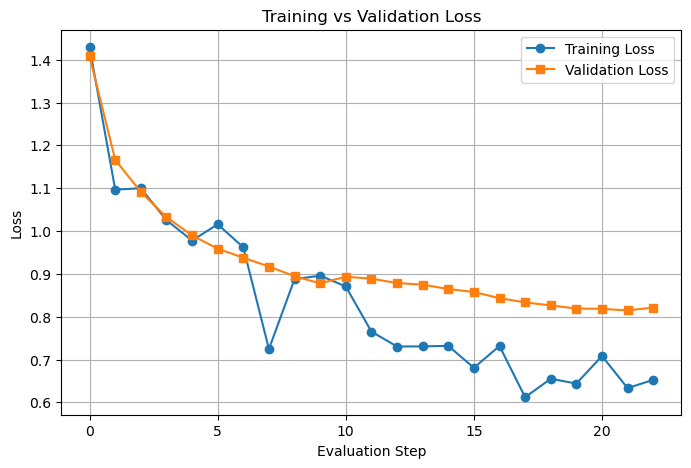

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss", marker="o")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss", marker="s")

plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
"""
    * This script is a safety check to ensure Ollama is running before your program tries to interact with it.
    * Imports the psutil library, which allows you to inspect and monitor system processes, CPU, memory, etc.
"""

import psutil

def check_if_running(process_name):  # checks if a process is running on your system.
    running = False
    # iterates over all active processes but only fetches their name attribute (faster than fetching full info).
    for proc in psutil.process_iter(['name']):
        # checks if the given process_name string is inside the process name.
        if process_name in proc.info['name']:
            running = True
            break
    return running

ollama_running = check_if_running('ollama')

if not ollama_running:
    raise RuntimeError(
        'Ollama not running. Launch ollama before proceeding.'
)
print('Ollama running:', check_if_running('ollama'))

Ollama running: True


In [34]:
"""
    * This function is a low-level client for Ollama’s REST API.
        - Builds a JSON payload with model + prompt + options.
        - Sends it to http://localhost:11434/api/chat.
        - Reads Ollama’s streaming JSON response line by line.
        - Concatenates the generated text into a single string.
        - Returns that text to the caller.
        
    * Imports Python’s built-in library for making HTTP requests (no external requests library needed).
"""

def query_model(
    prompt, 
    model='llama3', 
    url='http://localhost:11434/api/chat'
):
    data = {          
        'model': model,   # tells Ollama which LLM to use (e.g., llama3).
        'messages': [
            {'role': 'user', 'content': prompt} # in chat format.
        ],
        'options': {          # extra settings for generation
            'seed': 123,      # makes output deterministic (same input → same result).
            'temperature': 0, # makes model responses more focused/less random.
            'num_ctx': 2048   # maximum number of tokens in context (window size).
        }
    }

    # Converts the Python dictionary data → JSON string → UTF-8 encoded bytes.
    payload = json.dumps(data).encode('utf-8')   

    # Creates an HTTP POST request to the Ollama server.
    request = urllib.request.Request( 
        url,                    # Ollama server
        data=payload,           # Attaches the payload (JSON body).
        method='POST'           # reates an HTTP POST request to the Ollama server.
    )
    request.add_header('Content-Type', 'application/json')   

    # Send request + handle response
    response_data = ''
    with urllib.request.urlopen(request) as response:   # actually calls the Ollama API.
        while True:
            line = response.readline().decode('utf-8')  # convert from bytes to string.
            if not line:
                break
            response_json = json.loads(line)                      # parse JSON chunk.
            response_data += response_json['message']['content']  # Concatenates all chunks into response_data.

    # returns the full generated model output.
    return response_data

In [ ]:
"""
    * You’re choosing which model Ollama should use for inference.
"""

model = 'llama3' # is the identifier of the model installed in your Ollama server
result = query_model('What do Llamas eat?', model) # It sends your prompt/question ("What do Llamas eat?") to the Ollama REST API.
print(result) # Prints the model’s answer in your Python console.